In [2]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
import numpy as np
import plotly.graph_objects as go


### Correlation Matrix

In [3]:

df = pd.read_csv(r"C:\Users\MadiL\Thesis CodeBase\Cross-Sectional\lsas_together.csv")

lsas_columns = [col for col in df.columns if "LSAS" in col]
cfs_columns = [col for col in df.columns if "CFS" in col]
bdi_columns = [col for col in df.columns if "BDI" in col]


# Subset the dataframe
### If we want to use demographics, don't subset
df_subset = df[lsas_columns + cfs_columns + bdi_columns].copy()

#df_subset[cfs_columns] = abs(df_subset[cfs_columns])

# Reverse score CFS questions 2, 3, 5, 10 in place
reverse_columns = ['CFS_2', 'CFS_3', 'CFS_5', 'CFS_10']

# Apply the reverse scoring transformation in place
df_subset[reverse_columns] = 7 - df_subset[reverse_columns]

# Reverse the direction of all CFS columns by multiplying by -1
df_subset[cfs_columns] = df_subset[cfs_columns] * -1


# Normalize individual LSAS, CFS, and BDI questions without summing
def normalize(df, min_val, max_val):
    return (df - min_val) / (max_val - min_val)

# Normalize LSAS columns (range 0-3)
df_subset[lsas_columns] = normalize(df_subset[lsas_columns], 0, 6)

# Normalize CFS columns (range 1-6)
df_subset[cfs_columns] = normalize(df_subset[cfs_columns], 1, 6)

# Normalize BDI columns (range 0-3)
df_subset[bdi_columns] = normalize(df_subset[bdi_columns], 0, 3)

# Create a new DataFrame with all the normalized individual items
df_normalized = df_subset[lsas_columns + cfs_columns + bdi_columns]

# Display the first few rows to check the normalized data
print(df_normalized.head())

# Compute the correlation matrix on the normalized individual items
normalized_correlation_matrix = df_normalized.corr()

# Print the correlation matrix
print(normalized_correlation_matrix)



     LSAS_1    LSAS_2    LSAS_3    LSAS_4    LSAS_5    LSAS_6    LSAS_7  \
0  0.166667  0.166667  0.166667  0.166667  0.166667  0.166667  0.166667   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.333333  0.000000   
3  0.666667  0.333333  0.666667  0.666667  0.333333  0.666667  0.833333   
4  0.333333  0.666667  0.000000  0.000000  0.666667  1.000000  0.333333   

     LSAS_8    LSAS_9   LSAS_10  ...  BDI_Loss_Of_Interest  \
0  0.000000  0.000000  0.000000  ...              0.333333   
1  0.000000  0.000000  0.000000  ...              0.000000   
2  0.333333  0.333333  0.333333  ...              0.666667   
3  0.833333  0.500000  1.000000  ...              0.000000   
4  0.666667  0.333333  0.500000  ...              0.000000   

   BDI_Indecisiveness  BDI_Worthlessness  BDI_Loss_Of_Energy  \
0            0.666667           0.000000                 0.0   
1            0.000000           0.000000        

### Building a Network

In [5]:
correlation_matrix = normalized_correlation_matrix
# Set a correlation threshold to define a "strong" connection
threshold = 0.4

# Initialize an empty graph
G = nx.Graph()

# Add edges for pairs of questions that have a correlation above the threshold
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if np.abs(correlation_matrix.iloc[i, j]) > threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j],
                       weight=correlation_matrix.iloc[i, j])
            

# Number of nodes in the graph
print(f"Number of nodes: {G.number_of_nodes()}")

# Number of edges in the graph
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 56
Number of edges: 444


This loop goes through every pair of questions in your dataset:

i and j represent the indices of two different questions (columns) in the correlation matrix.
The if statement checks whether the absolute value of the correlation between these two questions is greater than the threshold you set (0.3).

If the correlation is strong enough, an edge is added to the graph, connecting the two questions.
Why It’s Important: This step is how you build your network. Each edge in the network represents a significant relationship between two symptoms. The weight of the edge is the correlation value, which can be useful if you want to consider the strength of the connections in later analysis. 

### Analyze the Network

Identify Central Symptoms: Find out which questions (symptoms) are most central or influential in the network using measures like degree centrality.

Detect Clusters: Look for clusters or communities of symptoms that are closely connected, which might indicate groups of symptoms that co-occur or influence each other.


In [9]:
# Centrality analysis
centrality = nx.degree_centrality(G)
print("Most central symptoms:", sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10])

# Community detection
from networkx.algorithms import community
communities = community.greedy_modularity_communities(G)
print("Detected communities:", [list(c) for c in communities])

Most central symptoms: [('LSAS_2', 0.43636363636363634), ('LSAS_11', 0.41818181818181815), ('LSAS_14', 0.41818181818181815), ('LSAS_19', 0.41818181818181815), ('LSAS_5', 0.39999999999999997), ('LSAS_7', 0.39999999999999997), ('LSAS_8', 0.39999999999999997), ('LSAS_12', 0.39999999999999997), ('LSAS_9', 0.3818181818181818), ('LSAS_16', 0.3818181818181818)]
Detected communities: [['LSAS_14', 'LSAS_5', 'LSAS_19', 'LSAS_6', 'LSAS_3', 'LSAS_21', 'LSAS_11', 'LSAS_2', 'CFS_5', 'LSAS_4', 'LSAS_24', 'LSAS_10', 'LSAS_23', 'LSAS_8', 'LSAS_9', 'LSAS_16', 'LSAS_1', 'LSAS_7', 'CFS_2', 'LSAS_13', 'LSAS_20', 'LSAS_18', 'LSAS_12', 'LSAS_22', 'CFS_10', 'LSAS_17', 'CFS_3', 'LSAS_15'], ['BDI_Past_Failure', 'BDI_Loss_Of_Energy', 'BDI_Sadness', 'BDI_Agitation', 'BDI_Guilty_Feelings', 'BDI_Pessimism', 'BDI_Changes_In_Sleeping_Pattern', 'BDI_Worthlessness', 'BDI_Irritability', 'BDI_Loss_Of_Interest', 'BDI_Indecisiveness', 'BDI_Tiredness_Or_Fatigue', 'BDI_Loss_Of_Pleasure', 'BDI_Crying', 'BDI_Punishment_Feeling

### Visualize the Network

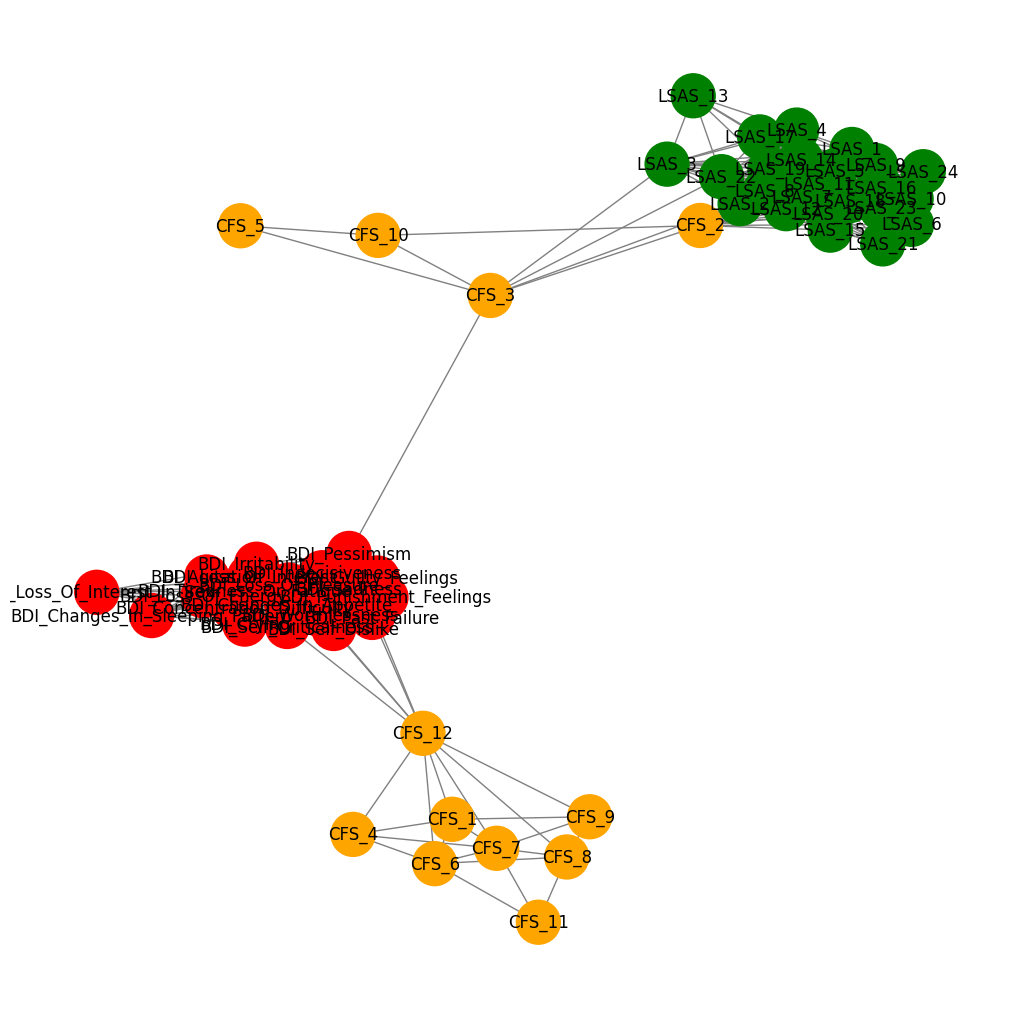

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Define a function to color nodes based on their survey type
def get_node_color(node):
    if "LSAS" in node:
        return 'green'
    elif "CFS" in node:
        return 'orange'
    elif "BDI" in node:
        return 'red'
    else:
        return 'gray'  # Default color for unrecognized nodes

# Assign colors to nodes based on their labels
node_colors = [get_node_color(node) for node in G.nodes]

# Define node positions using spring layout
pos = nx.spring_layout(G)  # You can also try other layouts like nx.circular_layout(G)

# Create the plot
plt.figure(figsize=(10, 10))

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, edge_color='gray')

# Show the plot
plt.show()



### Most/Least Connected Nodes

Shows nodes (questions) with the most and least degrees (number of connected edges)

In [11]:
import networkx as nx

# Assuming G is your graph from the previous steps

# Calculate the degree of each node
degree_dict = dict(G.degree())

# Find the most connected question(s)
most_connected = max(degree_dict, key=degree_dict.get)
most_connected_degree = degree_dict[most_connected]

# Find the least connected question(s)
least_connected = min(degree_dict, key=degree_dict.get)
least_connected_degree = degree_dict[least_connected]

# Print the results
print(f"Most connected question: {most_connected}: degree {most_connected_degree}")
print(f"Least connected question: {least_connected}: degree {least_connected_degree}")

# Sort nodes by their degree in descending order
sorted_degree = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)

# Print the results
print("Questions and their degrees (from highest to lowest):")
for question, degree in sorted_degree:
    print(f"{question}: {degree}")

Most connected question: LSAS_2: degree 24
Least connected question: CFS_5: degree 2
Questions and their degrees (from highest to lowest):
LSAS_2: 24
LSAS_11: 23
LSAS_14: 23
LSAS_19: 23
LSAS_5: 22
LSAS_7: 22
LSAS_8: 22
LSAS_12: 22
LSAS_9: 21
LSAS_16: 21
LSAS_18: 21
LSAS_20: 21
LSAS_22: 21
LSAS_23: 21
LSAS_10: 20
BDI_Pessimism: 20
BDI_Self_Criticalness: 20
BDI_Worthlessness: 20
LSAS_1: 19
BDI_Self_Dislike: 19
BDI_Loss_Of_Pleasure: 19
BDI_Loss_Of_Interest: 19
BDI_Loss_Of_Energy: 19
BDI_Irritability: 19
BDI_Concentration_Difficulty: 19
BDI_Tiredness_Or_Fatigue: 19
LSAS_24: 18
LSAS_15: 18
BDI_Past_Failure: 18
BDI_Agitation: 18
BDI_Changes_In_Appetite: 18
CFS_2: 17
BDI_Sadness: 17
BDI_Guilty_Feelings: 17
BDI_Punishment_Feelings: 17
BDI_Crying: 17
BDI_Indecisiveness: 17
LSAS_17: 16
LSAS_6: 16
LSAS_3: 15
LSAS_4: 14
LSAS_21: 13
BDI_Changes_In_Sleeping_Pattern: 12
CFS_12: 11
BDI_Loss_Of_Interest_In_Sex: 8
CFS_3: 7
CFS_7: 7
LSAS_13: 6
CFS_6: 6
CFS_1: 5
CFS_8: 5
CFS_4: 4
CFS_9: 4
CFS_10: 3
CFS_11

### Correlation Pairs (within-test allowed)

In [12]:
import pandas as pd
import numpy as np

# Assuming correlation_matrix is your DataFrame with correlations

# Set the diagonal elements to NaN to avoid self-pairing
np.fill_diagonal(correlation_matrix.values, np.nan)

# Find the maximum correlation value in the matrix
max_corr = correlation_matrix.max().max()

# Find the minimum correlation value in the matrix
min_corr = correlation_matrix.min().min()

# Find the pairs with the maximum correlation
max_corr_pairs = np.where(correlation_matrix == max_corr)
max_corr_questions = list(zip(correlation_matrix.columns[max_corr_pairs[0]], correlation_matrix.columns[max_corr_pairs[1]]))

# Find the pairs with the minimum correlation
min_corr_pairs = np.where(correlation_matrix == min_corr)
min_corr_questions = list(zip(correlation_matrix.columns[min_corr_pairs[0]], correlation_matrix.columns[min_corr_pairs[1]]))

# Print the results
print(f"Maximum correlation value: {max_corr}")
print("Pairs with the maximum correlation:")
for pair in max_corr_questions:
    print(f"{pair[0]} and {pair[1]}")

print(f"\nMinimum correlation value: {min_corr}")
print("Pairs with the minimum correlation:")
for pair in min_corr_questions:
    print(f"{pair[0]} and {pair[1]}")



Maximum correlation value: 0.8243014329145757
Pairs with the maximum correlation:
LSAS_11 and LSAS_12
LSAS_12 and LSAS_11

Minimum correlation value: 0.03063304445181655
Pairs with the minimum correlation:
LSAS_6 and CFS_11
CFS_11 and LSAS_6


In [ ]:
import pandas as pd
import numpy as np

# Assuming correlation_matrix is your DataFrame with correlations

# Set the diagonal elements to NaN to avoid self-pairing
np.fill_diagonal(correlation_matrix.values, np.nan)

# Function to determine if two columns belong to different tests
def different_tests(col1, col2):
    if (col1 in lsas_columns and col2 in lsas_columns) or \
       (col1 in cfs_columns and col2 in cfs_columns) or \
       (col1 in bdi_columns and col2 in bdi_columns):
        return False
    return True

# Function to get top N unique pairs (max or min correlations)
def get_top_n_pairs(correlation_matrix, n, max_or_min="max"):
    # Flatten the matrix to get correlations and pairs
    corr_unstacked = correlation_matrix.unstack()
    
    # Sort by correlation value
    if max_or_min == "max":
        sorted_corr = corr_unstacked.sort_values(ascending=False)
    else:
        sorted_corr = corr_unstacked.sort_values(ascending=True)
    
    # Filter out reverse pairs and pairs from the same test
    unique_pairs = []
    seen = set()
    for (col1, col2), corr_value in sorted_corr.items():
        if (col1, col2) not in seen and (col2, col1) not in seen and different_tests(col1, col2):
            unique_pairs.append((col1, col2, corr_value))
            seen.add((col1, col2))
            seen.add((col2, col1))  # Mark reverse pair as seen
        if len(unique_pairs) == n:
            break
    return unique_pairs

# Get 5 unique pairs with the highest correlations
highest_corr_pairs = get_top_n_pairs(correlation_matrix, 5, max_or_min="max")

# Get 5 unique pairs with the lowest correlations
lowest_corr_pairs = get_top_n_pairs(correlation_matrix, 5, max_or_min="min")

# Print the results
print("Top 5 pairs with the highest correlation (from different tests):")
for pair in highest_corr_pairs:
    print(f"{pair[0]} and {pair[1]} with correlation {pair[2]:.4f}")

print("\nTop 5 pairs with the lowest correlation (from different tests):")
for pair in lowest_corr_pairs:
    print(f"{pair[0]} and {pair[1]} with correlation {pair[2]:.4f}")


Top 5 pairs with the highest correlation (from different tests):
CFS_2 and LSAS_Fear_11 with correlation 0.5268
LSAS_Fear_12 and CFS_2 with correlation 0.5121
LSAS_Avoidance_11 and CFS_2 with correlation 0.5045
CFS_2 and LSAS_Fear_16 with correlation 0.4970
CFS_2 and LSAS_Fear_15 with correlation 0.4944

Top 5 pairs with the lowest correlation (from different tests):
BDI_Past_Failure and CFS_12 with correlation -0.4486
CFS_12 and BDI_Worthlessness with correlation -0.4477
BDI_Self_Dislike and CFS_12 with correlation -0.4476
BDI_Pessimism and CFS_12 with correlation -0.4205
CFS_12 and BDI_Self_Criticalness with correlation -0.4037


# Next steps: 

Find out how to stratify by type of test, so that I can see highest correlations between items of different tests. RIght now we're just getting the avoidance/fear equivalent questions from the LSAS. Also don't make it say the pair backwards.